## NBA Career Prediction Experiment

In [284]:
experiment_label = 'logreg03f_rev'

### Aim:
* To apply my improved undestanding of how to interpret validation results to improve model tuning.
* Week 1 result of this model was test AUC = 0.71032


### Findings:

Lower cv number gives more robust model. At cv=6, train and val scores are v close.
Specified to use roc_auc metric in cv.
Exploring L1 ratios

AUC results train, val:
* l1_ratio = 0 : 0.71, 0.71
* l1_ratio = 0.5 : same, although some cv runs failed to converge
* l1_ratio = 1 : same again. 

Let's go with l1_ratio = 0, ie l2 penalty.

Revisting the features:
* exclude that original set 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB' : slight recall (val 0,1) improvement from 0.65, 0.62 up to 0.67, 0.62 . AUC still 0.71. 

Submit
* Let's submit to test: result = 0.71125.
* That is an improvement on Week 1, where I was using too many cv iterations!


## Set up

In [285]:
import pandas as pd
import numpy as np
from joblib import dump, load  # simpler than pickle!
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [286]:
#load data

data_path = '../data/raw/uts-advdsi-nba-career-prediction'

train_raw = pd.read_csv(data_path + '/train.csv')
test_raw = pd.read_csv(data_path + '/test.csv')


In [287]:
#shapes & head

print(train_raw.shape)
print(test_raw.shape)

train_raw.head()

(8000, 22)
(3799, 21)


,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1


In [288]:
test_raw.head()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9


In [289]:
# info
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 22 columns):
Id_old         8000 non-null int64
Id             8000 non-null int64
GP             8000 non-null int64
MIN            8000 non-null float64
PTS            8000 non-null float64
FGM            8000 non-null float64
FGA            8000 non-null float64
FG%            8000 non-null float64
3P Made        8000 non-null float64
3PA            8000 non-null float64
3P%            8000 non-null float64
FTM            8000 non-null float64
FTA            8000 non-null float64
FT%            8000 non-null float64
OREB           8000 non-null float64
DREB           8000 non-null float64
REB            8000 non-null float64
AST            8000 non-null float64
STL            8000 non-null float64
BLK            8000 non-null float64
TOV            8000 non-null float64
TARGET_5Yrs    8000 non-null int64
dtypes: float64(18), int64(4)
memory usage: 1.3 MB


In [290]:
#variable descriptions
train_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,6856.971000,7798.50000,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,...,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,3977.447579,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,4.000000,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,3413.750000,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,6787.500000,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,10299.250000,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,13798.000000,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [291]:
test_raw.describe()

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,...,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,7010.614109,1899.000000,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,...,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,3954.173641,1096.821164,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,...,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,1.000000,0.000000,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,...,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,3644.000000,949.500000,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,...,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,7062.000000,1899.000000,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,...,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,10402.500000,2848.500000,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,...,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,13792.000000,3798.000000,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,...,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


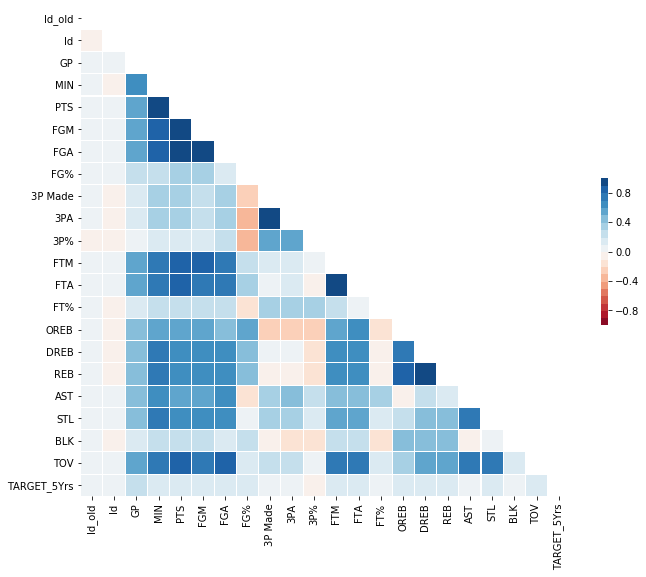

In [292]:
#correlation of potential features

corr = train_raw.corr('pearson')

#hide the top triangle, set fig and axes, choose colours
mask = np.triu(np.ones_like(corr, dtype=bool))   
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("RdBu", 20)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.05, cbar_kws={"shrink": .3})

In [293]:
corr

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id_old,1.000000,-0.010224,0.028860,0.027481,0.023416,0.023845,0.024341,0.009777,0.008947,0.009524,...,0.017460,0.018887,0.014007,0.018180,0.018471,0.017703,0.007974,0.011955,0.021505,0.018233
Id,-0.010224,1.000000,0.003940,-0.002747,0.003048,0.001812,0.000376,0.010359,-0.009092,-0.005847,...,0.008845,-0.003565,-0.004322,-0.004517,-0.004924,0.008069,0.013752,-0.005705,0.013185,0.006645
GP,0.028860,0.003940,1.000000,0.608090,0.578344,0.577697,0.553374,0.278510,0.123231,0.119146,...,0.519154,0.155667,0.402654,0.492070,0.484485,0.402126,0.473409,0.187269,0.537821,0.242108
MIN,0.027481,-0.002747,0.608090,1.000000,0.904840,0.895957,0.895085,0.234919,0.358597,0.372454,...,0.753660,0.212366,0.542782,0.770128,0.728842,0.639013,0.759933,0.260428,0.792059,0.182203
PTS,0.023416,0.003048,0.578344,0.904840,1.000000,0.989208,0.973297,0.301991,0.337786,0.349452,...,0.842903,0.257157,0.539289,0.690687,0.673621,0.573893,0.678514,0.232923,0.816414,0.182004
FGM,0.023845,0.001812,0.577697,0.895957,0.989208,1.000000,0.972670,0.343140,0.288906,0.299300,...,0.798366,0.208038,0.565086,0.699456,0.689229,0.550682,0.663419,0.245199,0.799119,0.183568
FGA,0.024341,0.000376,0.553374,0.895085,0.973297,0.972670,1.000000,0.140998,0.373362,0.399025,...,0.761174,0.263515,0.464325,0.635072,0.607930,0.619597,0.689391,0.191895,0.816810,0.162389
FG%,0.009777,0.010359,0.278510,0.234919,0.301991,0.343140,0.140998,1.000000,-0.269994,-0.330586,...,0.335512,-0.187200,0.539317,0.429142,0.490902,-0.132006,0.071364,0.288155,0.128622,0.158858
3P Made,0.008947,-0.009092,0.123231,0.358597,0.337786,0.288906,0.373362,-0.269994,1.000000,0.979340,...,0.088516,0.320845,-0.200575,0.076694,-0.014098,0.375967,0.305817,-0.094750,0.231413,0.015016
3PA,0.009524,-0.005847,0.119146,0.372454,0.349452,0.299300,0.399025,-0.330586,0.979340,1.000000,...,0.101186,0.335011,-0.213506,0.069782,-0.023208,0.409646,0.337407,-0.101143,0.255422,0.003463


### Observations

Strong correlation between
* MIN minutes played
* PTS points per game  ***
* FGM field goals made
* FGA field goal attempts
* TOV turnovers

Strong correlation between
* 3pt attempts
* 3pt made  ***

Strong correlation between
* free throw attempts
* free throw made
* PTS points per game ***

Strong correlation between
* rebounds
* (off and def rebounds) ***

## Decisions

Exclude features listed above that are not marked with stars, in favour of those marked with stars.
Also include features not listed above.

and TARGET_5Yrs is our target.

## Cleaning

In [294]:
train = train_raw.copy()
test = test_raw.copy()

In [295]:
cols_drop = ['Id_old', 'Id', 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

In [296]:
train.head()

,GP,PTS,FG%,3P Made,3P%,FT%,OREB,DREB,AST,STL,BLK,TARGET_5Yrs
0,80,7.8,45.7,0.1,22.6,72.1,2.2,2.0,3.2,1.1,0.2,1
1,75,10.5,55.1,-0.3,34.9,67.8,3.6,3.7,0.7,0.5,0.6,1
2,85,4.5,42.8,0.4,34.3,75.7,0.6,1.8,0.8,0.4,0.2,1
3,63,8.2,52.5,0.3,23.7,66.9,0.8,2.0,1.8,0.4,0.1,1
4,63,3.7,50.8,0.5,13.7,54.0,2.4,2.7,0.4,0.4,0.6,1


In [297]:
test.head()

,GP,PTS,FG%,3P Made,3P%,FT%,OREB,DREB,AST,STL,BLK
0,56,4.0,43.7,0.1,7.3,63.4,1.2,0.8,0.4,0.2,0.3
1,43,10.1,46.0,0.6,35.1,75.3,0.5,0.9,3.5,0.6,0.0
2,82,11.3,45.6,0.5,44.8,71.2,1.3,3.3,2.5,1.3,0.3
3,86,18.8,42.9,0.5,13.5,70.9,1.5,3.2,4.1,0.9,0.1
4,58,4.7,40.0,0.5,38.7,76.9,0.2,0.6,1.5,0.5,-0.4


In [298]:
train_target = train.pop('TARGET_5Yrs')

# Modelling

In [299]:
#transformations

# fit scaler to training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train = scaler.fit_transform(train)
dump(scaler, '../models/aj_' + experiment_label + '_scaler.joblib')

# transform test data
test = scaler.transform(test)

In [300]:
#examine shapes

print('train:' + str(train.shape))
print('test:' + str(test.shape))

train:(8000, 11)
test:(3799, 11)


In [301]:
# split training into train & validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, train_target, test_size=0.2, random_state=8)


In [302]:
#import models
from sklearn.linear_model import LogisticRegressionCV 


In [303]:
# Define model

model = LogisticRegressionCV(class_weight='balanced',
                             Cs=20,
                             max_iter=300,
                             penalty='elasticnet',
                             solver='saga',
                             l1_ratios=[0],
                             scoring='roc_auc',
                             cv=6,
                             random_state=8)

In [304]:
#fit model to training data
model.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, class_weight='balanced', cv=6, l1_ratios=[0],
                     max_iter=300, penalty='elasticnet', random_state=8,
                     scoring='roc_auc', solver='saga')

In [305]:
#save model to file

dump(model,  '../models/aj_' + experiment_label + '.joblib')

['../models/aj_logreg03f_rev.joblib']

In [306]:
#predictions for train set

y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

## Evaluation

In [307]:
from sklearn import metrics


In [308]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.models.aj_metrics import confusion_matrix

In [310]:
# Show confusion matrix with labels

print("Training:")
print(confusion_matrix(y_train, y_train_preds))
print("Validation:")
print(confusion_matrix(y_val, y_val_preds))

Training:
        pred:0  pred:1
true:0     712     362
true:1    1938    3388
Validation:
        pred:0  pred:1
true:0     172      85
true:1     510     833


In [311]:
print(metrics.classification_report(y_train, y_train_preds))
print(metrics.classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.27      0.66      0.38      1074
           1       0.90      0.64      0.75      5326

    accuracy                           0.64      6400
   macro avg       0.59      0.65      0.56      6400
weighted avg       0.80      0.64      0.69      6400

              precision    recall  f1-score   support

           0       0.25      0.67      0.37       257
           1       0.91      0.62      0.74      1343

    accuracy                           0.63      1600
   macro avg       0.58      0.64      0.55      1600
weighted avg       0.80      0.63      0.68      1600



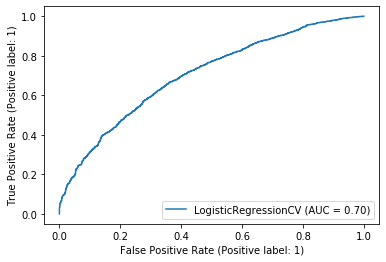

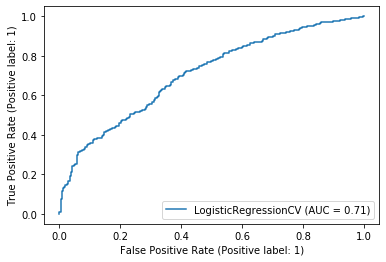

In [312]:
import matplotlib.pyplot as plt  
from sklearn import metrics
metrics.plot_roc_curve(model, X_train, y_train)
plt.show() 
metrics.plot_roc_curve(model, X_val, y_val)
plt.show() 

# Apply to test data for submission

In [313]:
y_test_preds = model.predict(test)


In [314]:
y_test_preds

array([0, 0, 1, ..., 0, 1, 0])

In [315]:
y_test_probs = model.predict_proba(test)

In [316]:
y_test_probs

array([[0.5298928 , 0.4701072 ],
       [0.55467761, 0.44532239],
       [0.27733164, 0.72266836],
       ...,
       [0.61657976, 0.38342024],
       [0.20342745, 0.79657255],
       [0.58217936, 0.41782064]])

In [317]:
len(y_test_probs)

3799

In [318]:
test_raw.shape

(3799, 21)

In [319]:
test_raw['Id'].shape

(3799,)

In [320]:
submission = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p[1] for p in y_test_probs]})

In [321]:
submission.head()

,Id,TARGET_5Yrs
0,0,0.470107
1,1,0.445322
2,2,0.722668
3,3,0.757473
4,4,0.419110


In [322]:
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',
                 index=False,
                 )